<a href="https://colab.research.google.com/github/RvsL/kaggle/blob/main/janestreet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import zipfile as zf
import os
import datetime as dt
from tqdm import tqdm, tqdm_notebook
import re
import string
import warnings
import matplotlib.pyplot as plt
import pickle

plt.style.use('ggplot')


def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name
def tstats(t, doplot = False):
    print('#'*20, get_df_name(t), t.shape)
    for _,i in enumerate(t):
        nulls = t[i].isna().sum()
        if nulls > 0:
            print(i,'=', t[i].nunique(), ',NULLS = ', nulls, ',% of nulls = ',round(100*nulls/t.shape[0]))
        else:
            print(i,'=', t[i].nunique())
    if doplot:
        print()
        print(t.sample(10))
        print()
warnings.filterwarnings('ignore')

def codeclasses(datavector, name, silent = False):
    encoder = LabelEncoder()
    encoder.fit(datavector.unique())
    if not silent:
        print('\n', name, ' encoding:\n')
        for i, item in enumerate(encoder.classes_):
            print(i,'-->',item)
    return encoder.transform(datavector)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# homedir = '../input/jane-street-market-prediction/'
homedir = '/content/drive/MyDrive/2 - рабочее/32 - PMI/random/'

In [2]:
fname = 'janestreet.pickle'
with open(f'{homedir}{fname}', 'rb') as handle:
    train = pickle.load(handle)

train = train.sample(10000)

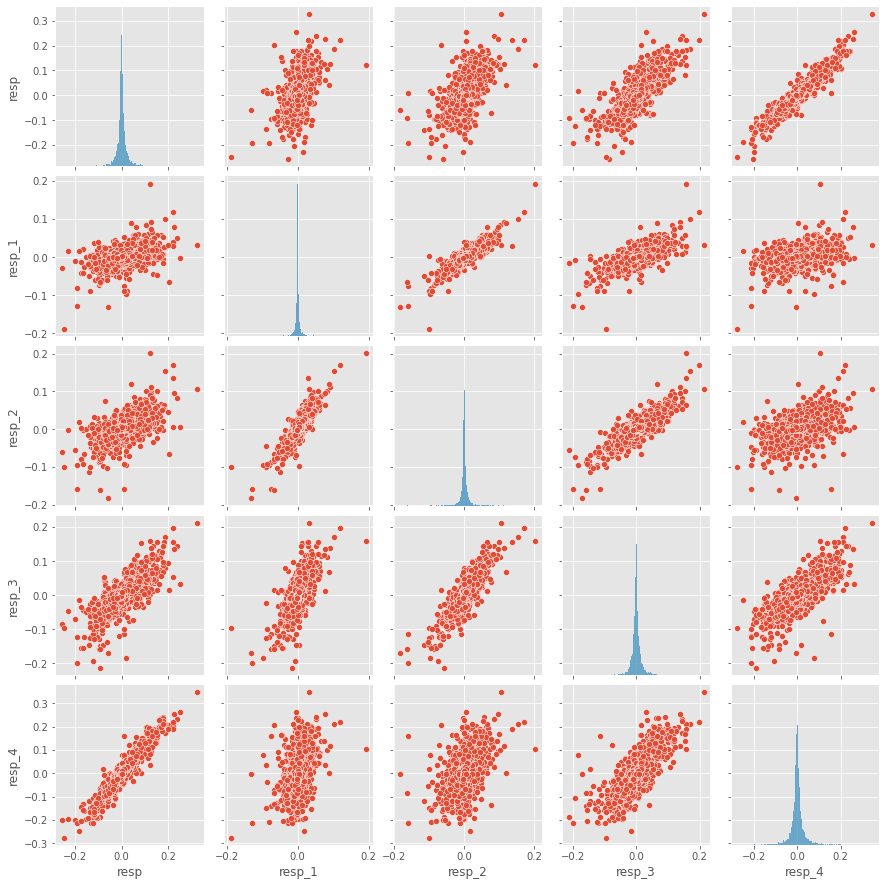

In [3]:
import seaborn as sns
# sns.set()

plt.style.use('ggplot')
cols = ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4']
sns.pairplot(train[cols])

In [4]:
features = [i for i in train.columns if ('feature_' in i)or(i == 'date')or(i == 'ts_id')]
target_0 = 'resp'
target_1 = 'resp_1'
target_2 = 'resp_2'
target_3 = 'resp_3'
target_4 = 'resp_4'

cols_0 = [*features, target_0]
cols_1 = [*features, target_1]
cols_2 = [*features, target_2]
cols_3 = [*features, target_3]
cols_4 = [*features, target_4]


In [5]:
!pip install catboost

In [6]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score,recall_score,precision_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold

In [13]:
def prepare_data(num):
    
    cols = globals()[f'cols_{num}']
    targ = globals()[f'target_{num}']
    
    t4m = train[cols].copy()
    
    return t4m, features, targ

params_cat = {
    'loss_function':'RMSE', 
    'eval_metric':'RMSE', 
    'iterations':10000,
    'task_type':'GPU',
    'verbose':False,
    'learning_rate':0.001
}

Fold 0:
0:	learn: 0.0280306	test: 0.0289543	best: 0.0289543 (0)	total: 13.3ms	remaining: 2m 13s
bestTest = 0.02891511046
bestIteration = 673
Shrink model to first 674 iterations.
Fold 1:
0:	learn: 0.0282506	test: 0.0285219	best: 0.0285219 (0)	total: 12.9ms	remaining: 2m 9s
1000:	learn: 0.0275881	test: 0.0283613	best: 0.0283612 (999)	total: 11.5s	remaining: 1m 43s
2000:	learn: 0.0270676	test: 0.0282937	best: 0.0282936 (1993)	total: 23.3s	remaining: 1m 32s
bestTest = 0.02828219331
bestIteration = 2356
Shrink model to first 2357 iterations.
Fold 2:
0:	learn: 0.0287324	test: 0.0275473	best: 0.0275473 (0)	total: 14ms	remaining: 2m 19s
1000:	learn: 0.0280908	test: 0.0274728	best: 0.0274728 (999)	total: 11.6s	remaining: 1m 44s
bestTest = 0.02746698015
bestIteration = 1220
Shrink model to first 1221 iterations.


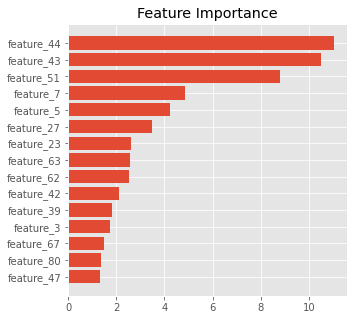

CPU times: user 56 s, sys: 16.7 s, total: 1min 12s
Wall time: 53.1 s


In [14]:
%%time
n_fold = 3
folds = KFold(n_splits=n_fold, shuffle=True, random_state=101)

t4m, feat, targ = prepare_data(0)

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(t4m)):
    print(f"Fold {n_fold}:")
    trn_x, trn_y = t4m[feat].iloc[trn_idx], t4m[targ].iloc[trn_idx]
    val_x, val_y = t4m[feat].iloc[val_idx], t4m[targ].iloc[val_idx]
    
    model = CatBoostRegressor(**params_cat)
    model.fit(trn_x, trn_y, 
            eval_set=(val_x, val_y), 
            verbose_eval=1000, 
            early_stopping_rounds=50)


importances = model.feature_importances_

target_results = pd.DataFrame(importances, columns=[targ])
target_results['feature'] = trn_x.columns

t = target_results.sort_values(by = targ)
t = t.tail(15)

plt.figure(figsize=(5, 5))
plt.title('Feature Importance')
plt.barh(t['feature'], t[targ])
plt.show()

fold 0, rmse = 0.02906904187490654
fold 1, rmse = 0.028170130860651066
fold 2, rmse = 0.027663174159620278


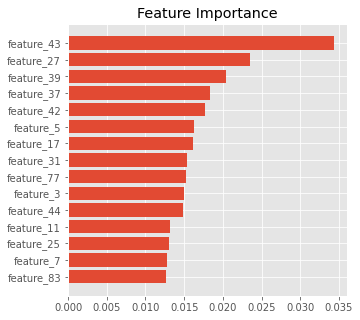

CPU times: user 13min 40s, sys: 108 ms, total: 13min 40s
Wall time: 13min 40s


In [8]:
%%time
n_fold = 3
folds = KFold(n_splits=n_fold, shuffle=True, random_state=101)

t4m, feat, targ = prepare_data(0)

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(t4m)):
#     print(f"Fold {n_fold}:")
    trn_x, trn_y = t4m[feat].iloc[trn_idx], t4m[targ].iloc[trn_idx]
    val_x, val_y = t4m[feat].iloc[val_idx], t4m[targ].iloc[val_idx]
    
    model = RandomForestRegressor()
    model.fit(trn_x, trn_y)
    
    preds = model.predict(val_x)
    
    rmse = np.sqrt(mean_squared_error(val_y, preds))
    print(f'fold {n_fold}, rmse = {rmse}')
    
importances = model.feature_importances_

target_results = pd.DataFrame(importances, columns=[targ])
target_results['feature'] = trn_x.columns

t = target_results.sort_values(by = targ)
t = t.tail(15)

plt.figure(figsize=(5, 5))
plt.title('Feature Importance')
plt.barh(t['feature'], t[targ])
plt.show()

In [9]:
t4m[targ].std()

0.028342960837212793